In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, ks_2samp

In [3]:
dataset = pd.read_csv('https://raw.githubusercontent.com/Doll03/4IZ480/main/Data/TimeDeposit_10K.csv', sep=";")


In [4]:
dataset.Time_Deposits_Flag.value_counts()


F    9897
T     103
Name: Time_Deposits_Flag, dtype: int64

In [5]:
dataset["Customer_ID"] = dataset["Customer_ID"].astype("object")
dataset["Birth_Date"] = dataset["Birth_Date"].astype("datetime64")
dataset["Ref_Date"] = dataset["Ref_Date"].astype("datetime64")
dataset["Gender"] = [True if i == "Male" else False for i in dataset['Gender']]# 1=Male 0=Female
dataset["Marital_Status"] = dataset["Marital_Status"].astype("category")
dataset["Children_Num"] = dataset["Children_Num"].astype("category")
dataset["Occupation_Category"] = dataset["Occupation_Category"].astype("category")
dataset["Payroll_Flag"] = dataset["Payroll_Flag"].astype("bool")
dataset["Business_Flag"] = dataset["Business_Flag"].astype("bool")
dataset["Saving_Current_Accounts_Flag"] = dataset["Saving_Current_Accounts_Flag"].astype("bool")
dataset["Investment_Products_Flag"] = dataset["Investment_Products_Flag"].astype("bool")
dataset["Insurance_Products_Flag"] = dataset["Insurance_Products_Flag"].astype("bool")
dataset["Business_Loans_Flag"] = dataset["Business_Loans_Flag"].astype("bool")
dataset["Housing_Loans_Flag"] = dataset["Housing_Loans_Flag"].astype("bool")
dataset["Consumer_Loans_Flag"] = dataset["Consumer_Loans_Flag"].astype("bool")
dataset["Credit_Cards_Flag"] = dataset["Credit_Cards_Flag"].astype("bool")
dataset["Time_Deposits_Flag"] = [True if i == "T" else False for i in dataset['Time_Deposits_Flag']]



In [6]:
dataset.Time_Deposits_Flag.value_counts()


False    9897
True      103
Name: Time_Deposits_Flag, dtype: int64

In [47]:
#Creating boolean variables 
dataset["Credit_Cards_Installments_Flag"] = [True if i > 0 else False for i in dataset['Credit_Cards_Installments']]
dataset["Credit_Cards_Payments_Flag"] = [True if i > 0 else False for i in dataset['Credit_Cards_Payments_Num']]
dataset["Credit_Cards_Purchases_Flag"] = [True if i > 0 else False for i in dataset['Credit_Cards_Purchases_Num']]
dataset["Credit_Cards_Witrhdrawals_Flag"] = [True if i > 0 else False for i in dataset['Credit_Cards_Witrhdrawals_Num']]
dataset["Internet_Trans_Flag"] = [True if i > 0 else False for i in dataset['Internet_Trans_Num']]
dataset["Deposit_Trans_Flag"] = [True if i > 0 else False for i in dataset['Deposit_Trans_Num']]
dataset["Payment_Trans_Flag"] = [True if i > 0 else False for i in dataset['Payment_Trans_Num']]
dataset["Transfer_Trans_Flag"] = [True if i > 0 else False for i in dataset['Transfer_Trans_Num']]
dataset["Withdrawl_Trans_Flag"] = [True if i > 0 else False for i in dataset['Withdrawl_Trans_Num']]

In [7]:
#Creating variable Age_Cat
dataset['Age'] = dataset['Ref_Date'].dt.year - dataset['Birth_Date'].dt.year
Age_Cat = pd.cut(dataset['Age'], bins=[0, 32.50, 51.50, 60.50, 150],labels=['Younger', 'LowerMid', 'UpperMid', 'Older'])
Age_Cat

0       LowerMid
1       LowerMid
2       UpperMid
3       UpperMid
4       LowerMid
          ...   
9995     Younger
9996    LowerMid
9997    LowerMid
9998    LowerMid
9999     Younger
Name: Age, Length: 10000, dtype: category
Categories (4, object): ['Younger' < 'LowerMid' < 'UpperMid' < 'Older']

In [52]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 52 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   Gender                            10000 non-null  bool    
 1   Marital_Status                    10000 non-null  category
 2   Children_Num                      10000 non-null  category
 3   Occupation_Category               10000 non-null  category
 4   Total_Income                      10000 non-null  float64 
 5   Payroll_Flag                      10000 non-null  bool    
 6   Business_Flag                     10000 non-null  bool    
 7   Saving_Current_Accounts_Flag      10000 non-null  bool    
 8   Investment_Products_Flag          10000 non-null  bool    
 9   Insurance_Products_Flag           10000 non-null  bool    
 10  Business_Loans_Flag               10000 non-null  bool    
 11  Housing_Loans_Flag                10000 non-null  bool 

In [8]:
dataset = dataset.drop(["Ref_Date","Birth_Date","Customer_ID","Age" ], axis = "columns")

In [10]:
#crealing list of categorical variables
cat_v_list = [i for i in list(dataset.columns) if (dataset[i].dtypes in ['O', 'bool', "category"])]
cat_v_list.remove('Time_Deposits_Flag')

#creating list of numerical variables
num_v_list = [i for i in list(dataset.columns) if i not in cat_v_list]
num_v_list.remove('Time_Deposits_Flag')
print("Num:", num_v_list, "end=", "Cat:", cat_v_list)


Num: ['Total_Income', 'Saving_Current_Balance', 'Investment_Products_Balance', 'Insurance_Balances', 'Business_Loans_Balance', 'Housing_Loans_Balance', 'Consumer_Loans_Balance', 'Credit_Cards_Balance', 'Branch_Trans_Num', 'ATM_Trans_Num', 'APS_Trans_Num', 'Phone_Trans_Num', 'Internet_Trans_Num', 'Deposit_Trans_Num', 'Withdrawl_Trans_Num', 'Payment_Trans_Num', 'Transfer_Trans_Num', 'Deposit_Trans_Amount', 'Withdrawl_Trans_Amount', 'Payment_Trans_Amount', 'Transfer_Trans_Amount', 'Credit_Cards_Installments', 'Credit_Cards_Payments_Num', 'Credit_Cards_Purchases_Num', 'Credit_Cards_Witrhdrawals_Num', 'Credit_Cards_Payments_Amount', 'Credit_Cards_Purchases_Amount', 'Credit_Cards_Witrhdrawals_Amount', 'Arrears_Months_Max'] end= Cat: ['Gender', 'Marital_Status', 'Children_Num', 'Occupation_Category', 'Payroll_Flag', 'Business_Flag', 'Saving_Current_Accounts_Flag', 'Investment_Products_Flag', 'Insurance_Products_Flag', 'Business_Loans_Flag', 'Housing_Loans_Flag', 'Consumer_Loans_Flag', 'Credit

In [18]:
len(num_v_list)


29

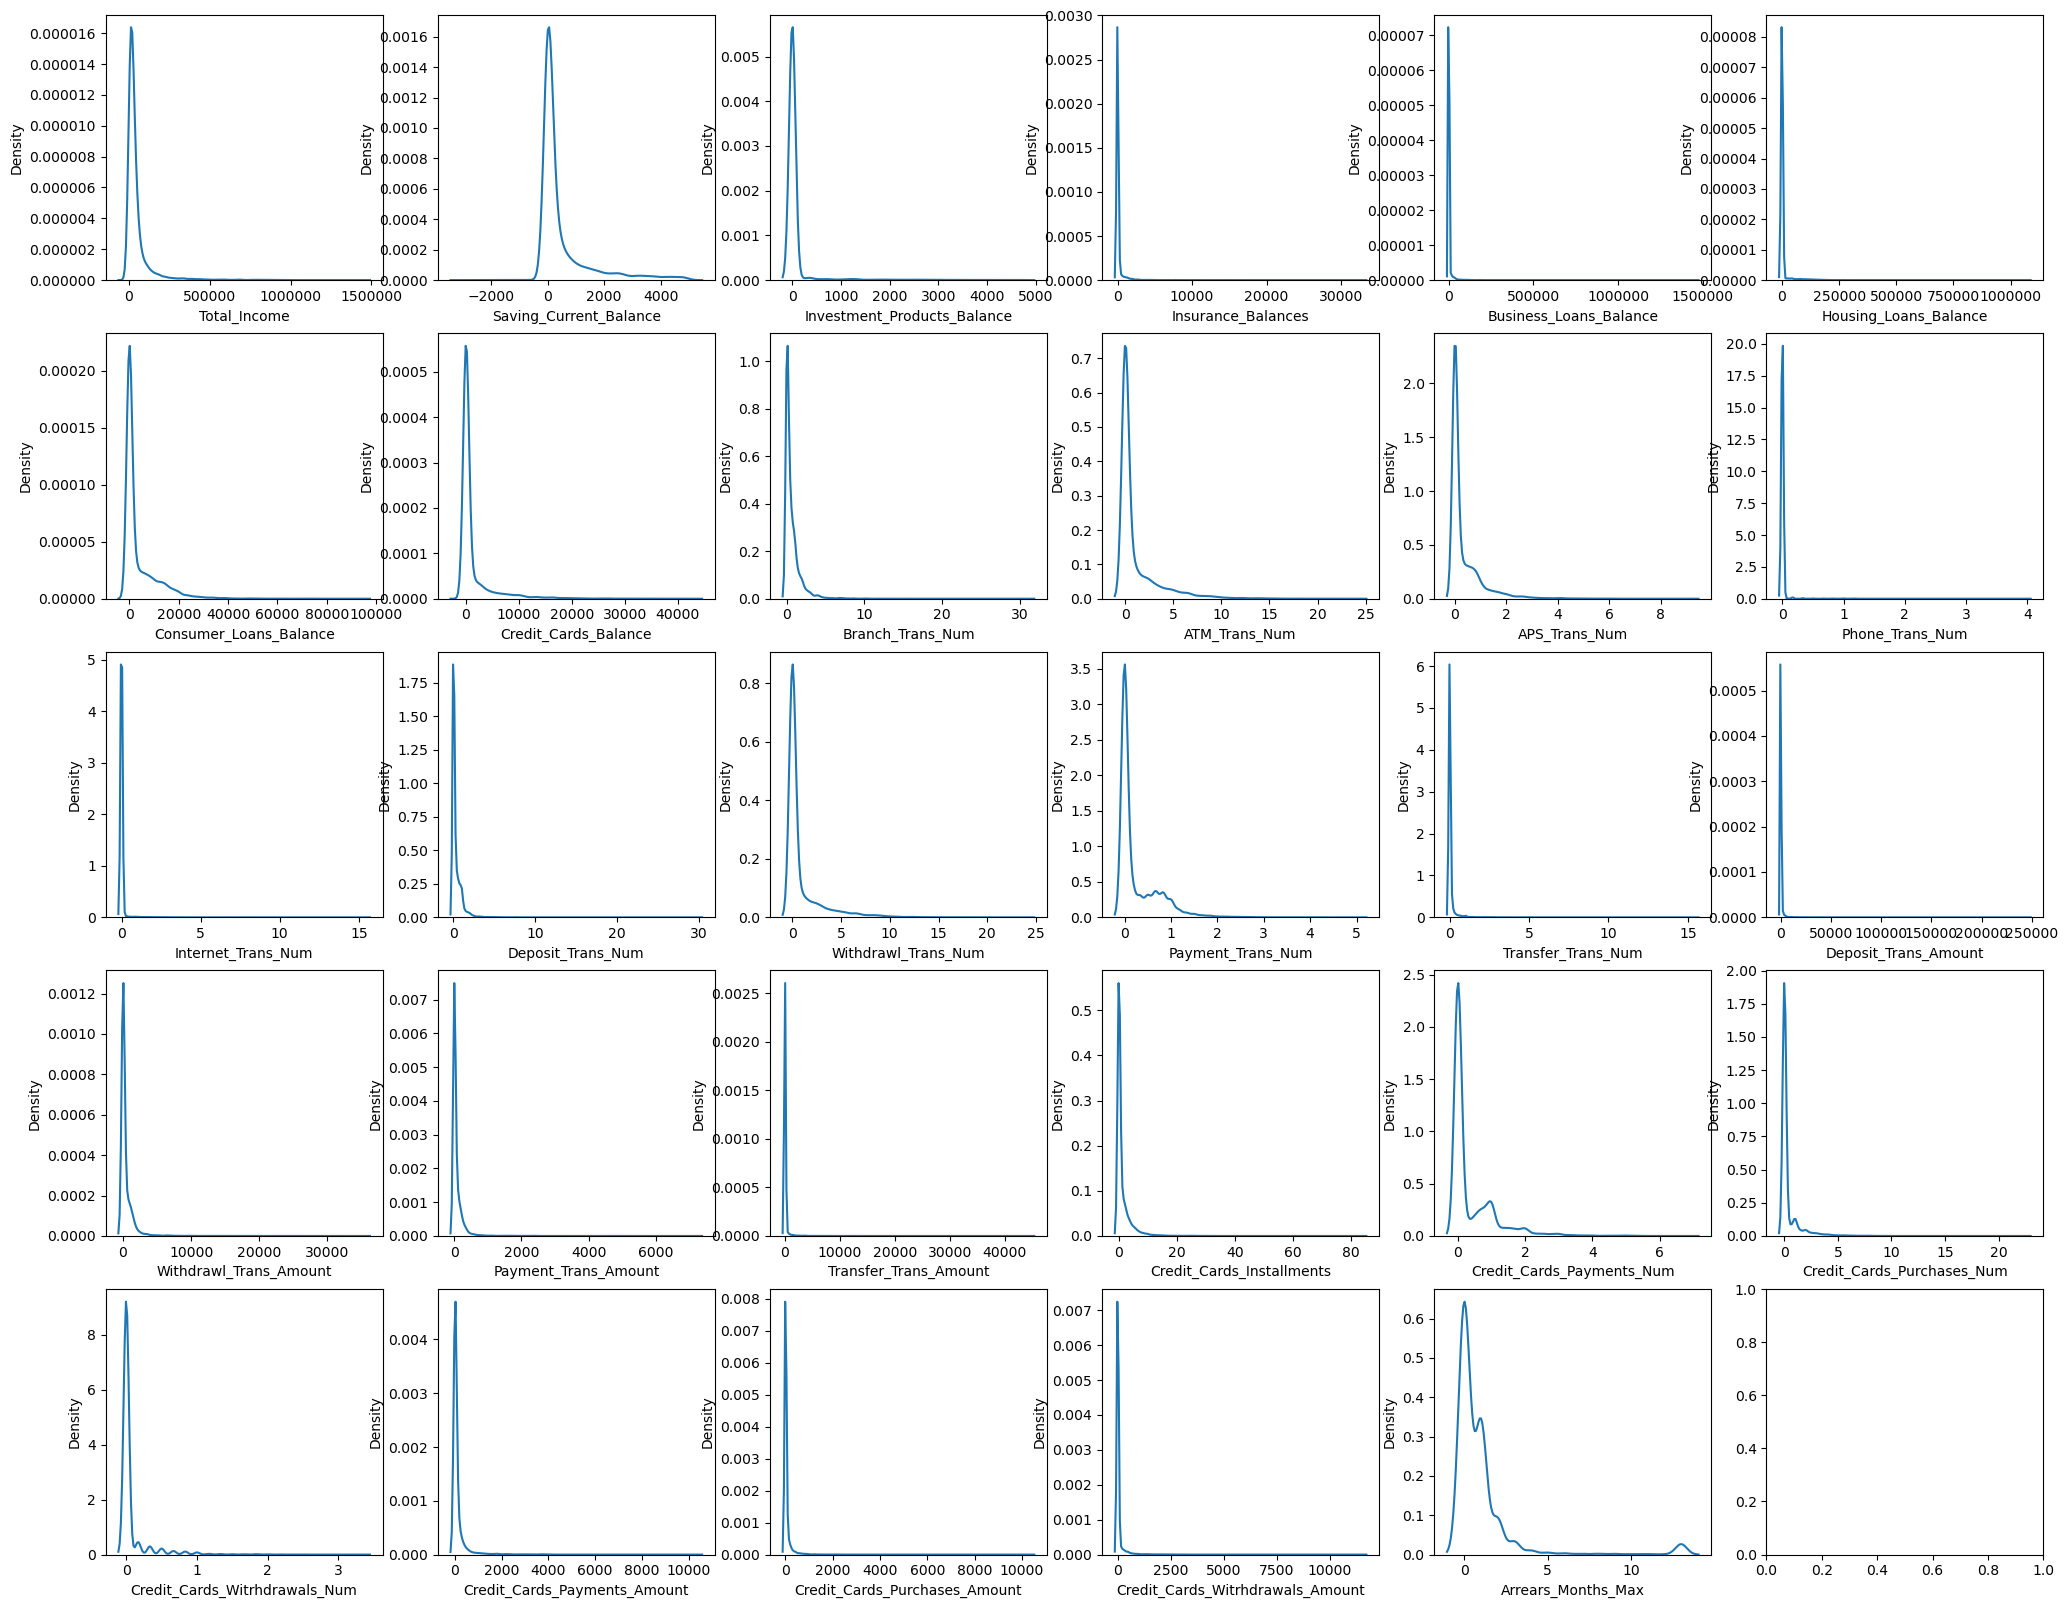

In [23]:
#Creating graphs and boxplots for storing numerical features
figure,axis = plt.subplots(5,6, figsize=(25,20))

for i,ax in zip(num_v_list,axis.ravel()):
    sns.kdeplot(data = dataset,x = i, ax = ax)
    ax.ticklabel_format(style = "plain", axis= "x")
    ax.ticklabel_format(style = "plain", axis= "y")



In [29]:
dataset["Time_Deposits_Flag"]=dataset["Time_Deposits_Flag"].astype("category")

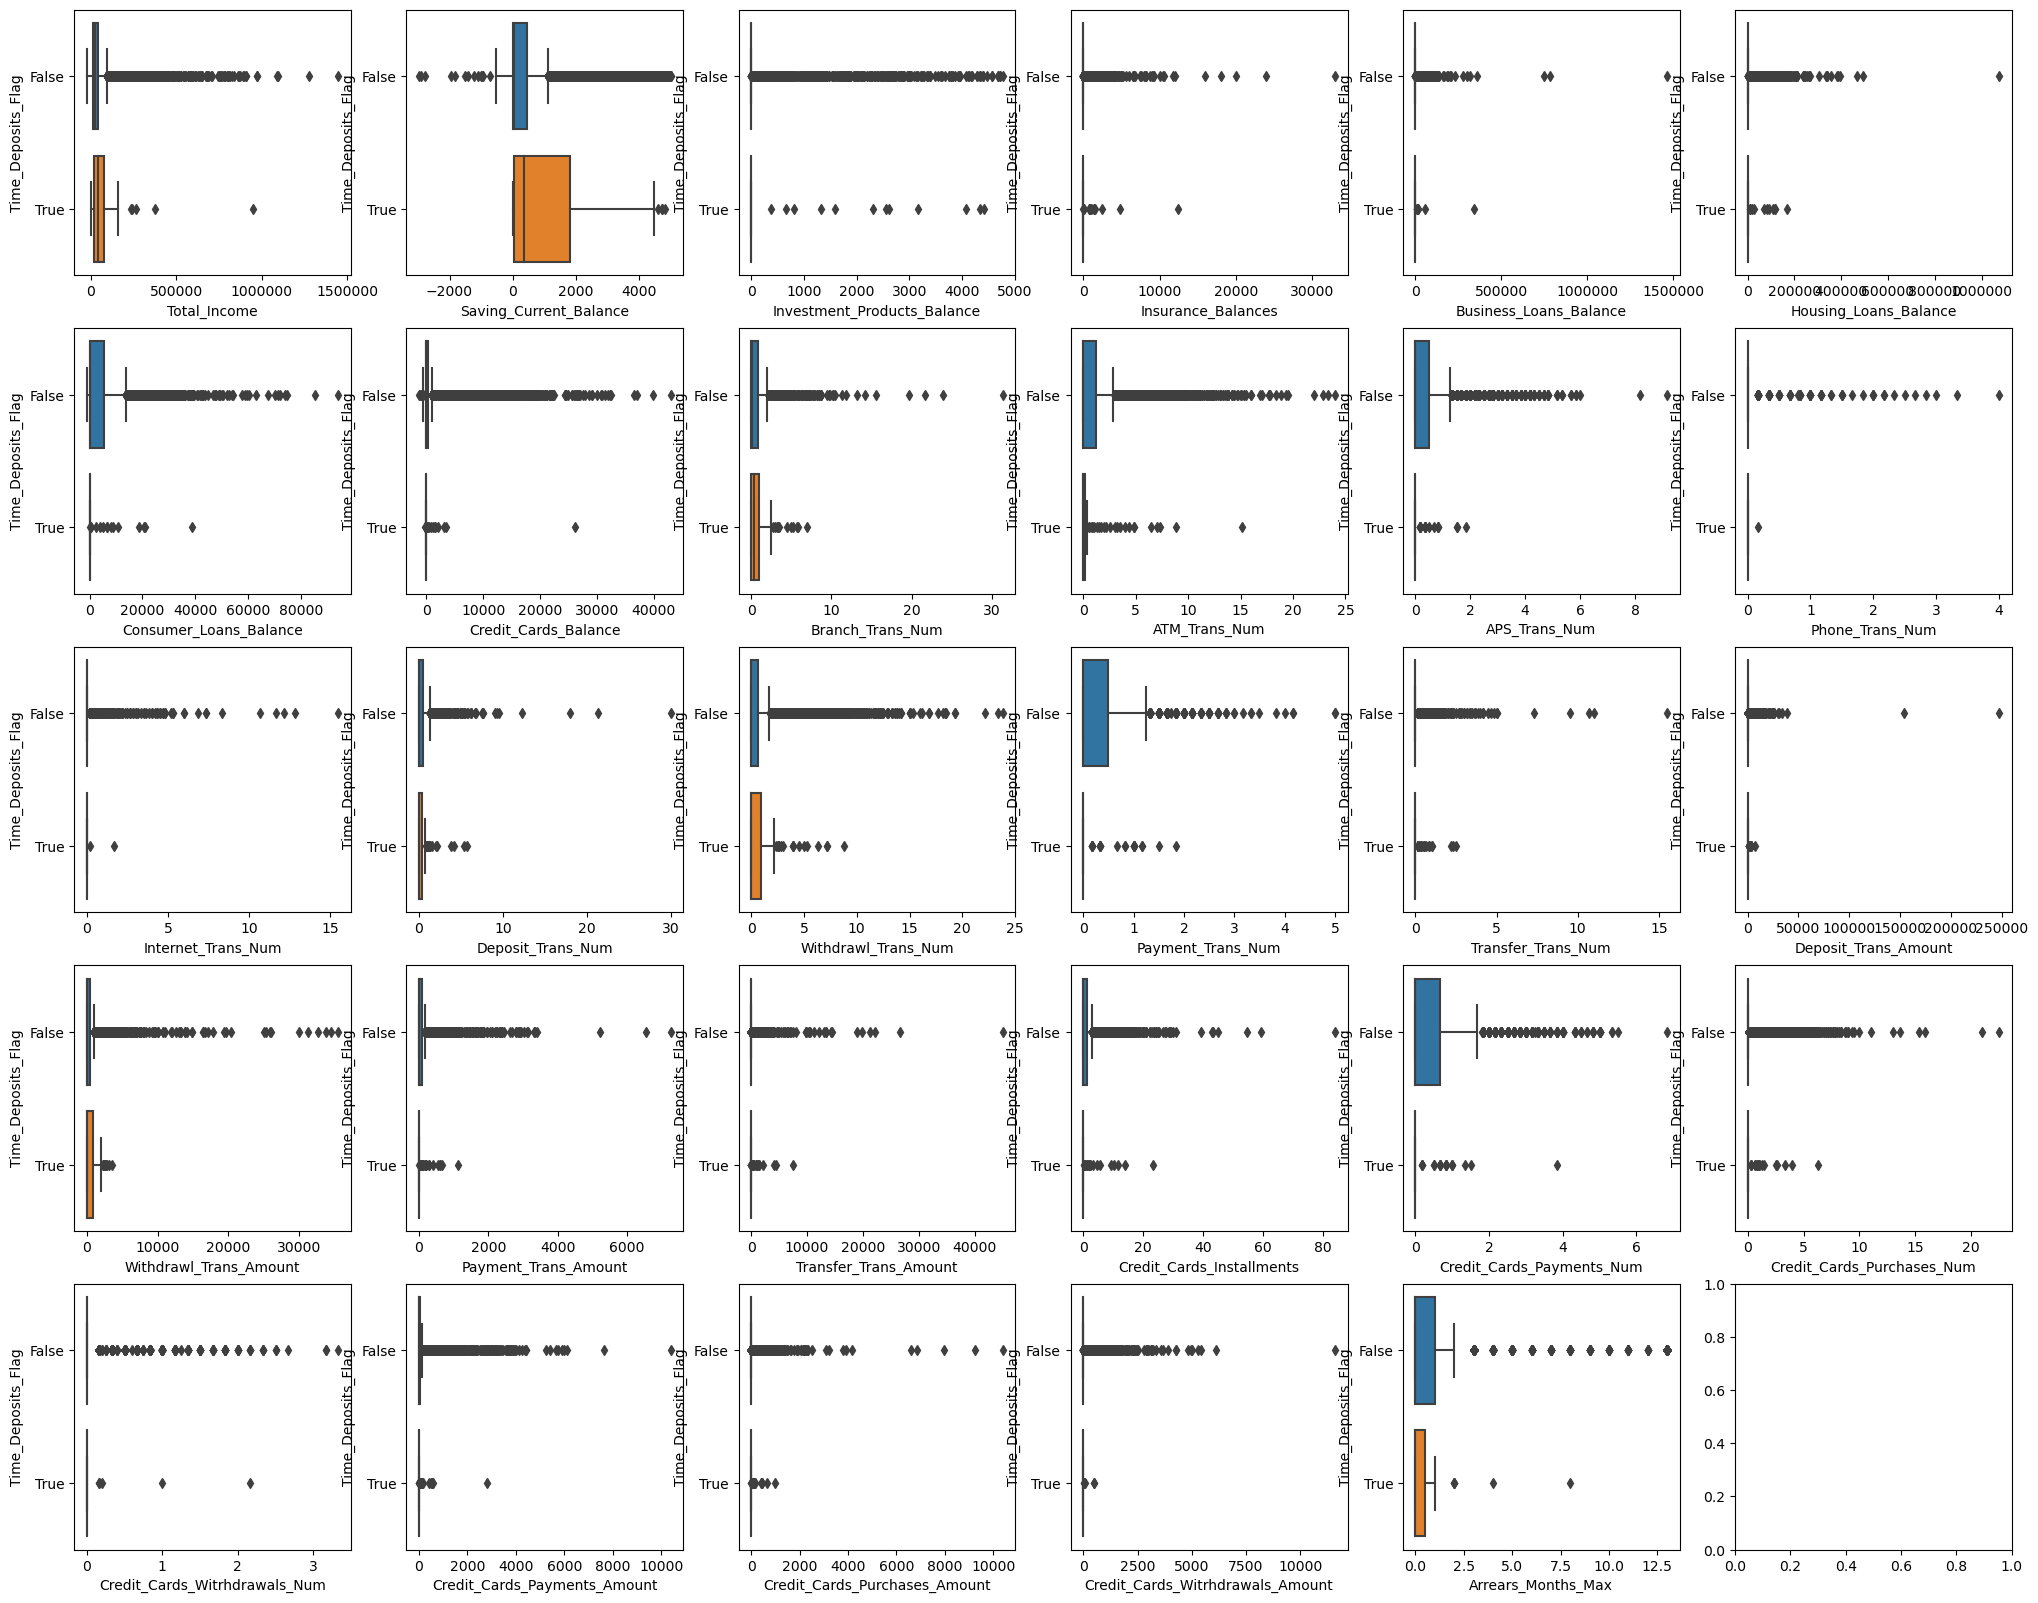

In [31]:
figure,axis = plt.subplots(5,6, figsize=(25,20))

for i,ax in zip(num_v_list,axis.ravel()):
    sns.boxplot(data = dataset,x = i, y="Time_Deposits_Flag", ax = ax)
    ax.ticklabel_format(style = "plain", axis= "x")
   

In [ ]:
#Creating a list and graphs for storing categorical features.
#cat_v_list = [i for i in list(dataset.columns) if i not in num_v_list]



['Gender', 'Marital_Status', 'Children_Num', 'Occupation_Category', 'Payroll_Flag', 'Business_Flag', 'Saving_Current_Accounts_Flag', 'Investment_Products_Flag', 'Insurance_Products_Flag', 'Business_Loans_Flag', 'Housing_Loans_Flag', 'Consumer_Loans_Flag', 'Credit_Cards_Flag', 'Saving_Current_Balance', 'Investment_Products_Balance', 'Insurance_Balances', 'Business_Loans_Balance', 'Housing_Loans_Balance', 'Consumer_Loans_Balance', 'Credit_Cards_Balance', 'Branch_Trans_Num', 'ATM_Trans_Num', 'APS_Trans_Num', 'Phone_Trans_Num', 'Internet_Trans_Num', 'Deposit_Trans_Num', 'Withdrawl_Trans_Num', 'Payment_Trans_Num', 'Transfer_Trans_Num', 'Deposit_Trans_Amount', 'Withdrawl_Trans_Amount', 'Payment_Trans_Amount', 'Transfer_Trans_Amount', 'Credit_Cards_Installments', 'Credit_Cards_Payments_Num', 'Credit_Cards_Purchases_Num', 'Credit_Cards_Witrhdrawals_Num', 'Credit_Cards_Payments_Amount', 'Credit_Cards_Purchases_Amount', 'Credit_Cards_Witrhdrawals_Amount', 'Arrears_Months_Max', 'Time_Deposits_Fla

['Gender', 'Marital_Status', 'Children_Num', 'Occupation_Category', 'Total_Income', 'Saving_Current_Balance', 'Investment_Products_Balance', 'Insurance_Balances', 'Business_Loans_Balance', 'Housing_Loans_Balance', 'Consumer_Loans_Balance', 'Credit_Cards_Balance', 'Branch_Trans_Num', 'ATM_Trans_Num', 'APS_Trans_Num', 'Phone_Trans_Num', 'Internet_Trans_Num', 'Deposit_Trans_Num', 'Withdrawl_Trans_Num', 'Payment_Trans_Num', 'Transfer_Trans_Num', 'Deposit_Trans_Amount', 'Withdrawl_Trans_Amount', 'Payment_Trans_Amount', 'Transfer_Trans_Amount', 'Credit_Cards_Installments', 'Credit_Cards_Payments_Num', 'Credit_Cards_Purchases_Num', 'Credit_Cards_Witrhdrawals_Num', 'Credit_Cards_Payments_Amount', 'Credit_Cards_Purchases_Amount', 'Credit_Cards_Witrhdrawals_Amount', 'Arrears_Months_Max', 'Age']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 54 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                     

In [ ]:

print(dataset["Time_Deposits_Flag"].value_counts(normalize=True))
sns.catplot(data = dataset, x = "Time_Deposits_Flag", kind = "count", palette = "ch:.79")

False    0.9897
True     0.0103
Name: Time_Deposits_Flag, dtype: float64
